# OD reactors database generation

In this notebook we will generate the database which will be used to train the neural networks. In this case, we consider 0D homogeneous reactors which, given an initial state, will ignite and reach a thermodynamical equilibrium (burned gas state). Each reactor is here parametrized by:

+ Initial temperature $T_0$
+ Equivalence ratio $\phi$ (constant throughout the simulation as there is no mixing)

The pressure will be assumed constant.

Using Google Colab:

In [1]:
use_colab = False

## Google colab preparation

These lines are here to enable Colab running of the tools. We need to perform a git clone in order to have access to python scripts. This needs to be done at each runtime as the clone is lost. 

In [2]:
import os

if use_colab:
    !git clone -b cost_course_exercices https://github.com/cmehl/ML_chem.git
    !pip install PyDOE
    !pip install cantera

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Create a folder in the root directory
    if not os.path.isdir("/content/drive/MyDrive/ML_chem_data"):
        !mkdir -p "/content/drive/MyDrive/ML_chem_data"
    else:
        print("Folder /content/drive/MyDrive/ML_chem_data already exists")

## Imports

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import json
import os
import pickle
import joblib

import numpy as np
import matplotlib.pyplot as plt

if use_colab:
    from ML_chem.chem_ai.database_homo import Database_HomoReac
    from ML_chem.chem_ai.utils import StandardScaler
else:
    from chem_ai.database_homo import Database_HomoReac
    from chem_ai.utils import StandardScaler


## 0D reactors simulations

We perform first the 0D reactors simulations in order to populate the database. A series of reactors are computed and results are stored in a dataframe. These reactors are solved here using the [CANTERA software](https://cantera.org/).

Some parameters are first set:

+ **folder**: folder path where the databases and models will be stored.
+ **p**: pressure, constant in this exercice.
+ **phi_bounds**: equivalence ratio bounds (min/max) for the initial conditions sampling.
+ **T0_bounds**: temperature bounds (min/max) for the initial conditions sampling.
+ **n_samples**: number of initial conditions sampled in the given bounds.
+ **fuel**: fuel species.
+ **mech_file**: yaml file for the CANTERA mechanism. Some mechanism are provided in *data/mechanisms*.
+ **solve_mode**: sets the chemical space sampling method, either using fixed time increments (*dt_cfd*) or increments based on solver (*dt_cvode*). In the second case, values $Y_k(t+dt)$ will need to be recomputed later for each point.
+ **max_sim_time**: limit time for a given 0D reactor to avoid problems with stopping criterion.
+ **dt**: time step value used for the ML database; and if *dt_cfd* method is chosen it corresponds to the actual *dt* in the database.

In [9]:
if use_colab:
    folder = "/content/drive/MyDrive/ML_chem_data/case_0D_" + "test"
else:
    folder = "case_0D_" + "test"


#Sampling parameters
p = 101325.0
phi_bounds = (0.8, 1.0)
T0_bounds = (1600.0, 1800.0)
n_samples = 500

# Chemistry parameters
fuel = "H2"
mech_file = "./data/mechanisms/mech_h2.yaml"

# Simulations parameters
solve_mode = "dt_cfd"   # dt_cvode or dt_cfd
max_sim_time = 10.0e-3
dt = 1.0e-6


The class *Database_HomoReac* includes functions to compute the reactors and to build the training and validation datasets $(X_{train}, Y_{train})$ and $(X_{val}, Y_{val})$.

We instantiate the database using the parameters defined above. At instantation (in the *init* function of the class), several operations are performed:

+ A design of Experiment is done: a set of *n_samples* $(T_0,\phi)$ couples is selected based on Latin Hypercube Sampling (LHS)
+ The corresponding 0D reactors are run and the results are stored.

T0=1775.3607201074374; phi=0.9694105914515878
T0=1794.1461749409723; phi=0.9824175296332056
T0=1679.3912385514652; phi=0.8146064650076553
T0=1704.2990795929356; phi=0.8255626210955272
T0=1770.2045601283035; phi=0.9093221696735367
T0=1694.201727822701; phi=0.9066501706546063
T0=1621.055913535711; phi=0.9578668988080599
T0=1657.2262862062053; phi=0.8540868816706806
T0=1677.527181961798; phi=0.9617522415005733
T0=1767.43328824144; phi=0.851856603128392
T0=1765.194154055334; phi=0.8903165148506672
T0=1617.1145477552338; phi=0.8593579364189786
T0=1777.2263037504215; phi=0.8306704308596932
T0=1654.5472177948661; phi=0.9224215369033182
T0=1786.3932030842168; phi=0.8478922715037095
T0=1765.5038276154482; phi=0.829268380560039
T0=1678.5718929360876; phi=0.9212293831584704
T0=1603.2123392570968; phi=0.895744899089281
T0=1640.6048973566058; phi=0.9298909909852145
T0=1721.9762458219245; phi=0.952064718757074
T0=1754.392428545371; phi=0.8658713587746771
T0=1697.7705689790132; phi=0.8533137056974176

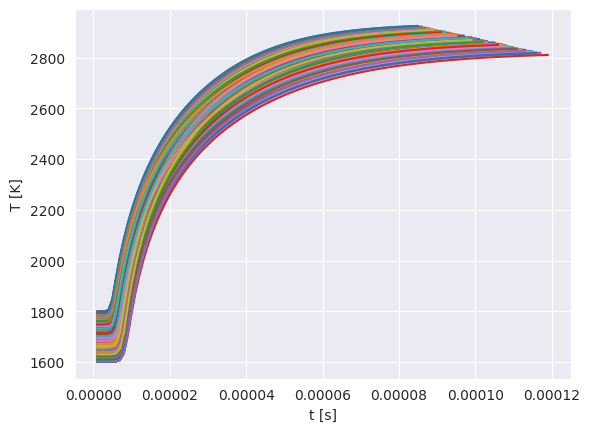

In [10]:
dtb = Database_HomoReac(mech_file, fuel, folder, p, phi_bounds, T0_bounds, n_samples, dt, max_sim_time, solve_mode)

The design of experiments is stored in the *df_ODE* pandas dataframe, and each conditions is assinged a simulation number:

In [11]:
dtb.df_ODE.head()

,Phi,T0,sim_number
0,0.969411,1775.360720,0
1,0.982418,1794.146175,1
2,0.814606,1679.391239,2
3,0.825563,1704.299080,3
4,0.909322,1770.204560,4


The results of the 0D reactors simulations are concatenated in a pandas dataframe named *data_simu*. The necessary data for characterizing states ($T$, $p$ and $Y_k$) are included in the table, as well as the simulation number it sorrespond to and the simulation time. Attribution of states to simulation will be used to generate the train/validation/test databases.

This dataframe is solved in the **folder** ad *0D_runs.csv* and may be read in a separate notebook if we need.

We can visualize the dataframe:

In [12]:
dtb.data_simu.head()

,Temperature,Pressure,H,H2,O,O2,OH,H2O,N2,HO2,H2O2,Time,Simulation number
0,1775.360720,101325.0,0.000000e+00,0.027690,0.000000e+00,0.226548,0.000000e+00,0.000000,0.745762,0.000000,0.000000e+00,0.000000,0.0
1,1775.349360,101325.0,2.648830e-07,0.027690,7.289147e-07,0.226540,9.271610e-07,0.000004,0.745762,0.000003,3.422667e-08,0.000001,0.0
2,1775.365396,101325.0,3.063327e-06,0.027680,8.662625e-06,0.226468,1.101190e-05,0.000061,0.745762,0.000006,8.940156e-08,0.000002,0.0
3,1775.680607,101325.0,3.248716e-05,0.027574,9.219426e-05,0.225725,1.171610e-04,0.000684,0.745762,0.000013,1.813350e-07,0.000003,0.0
4,1779.157927,101325.0,3.285224e-04,0.026507,9.427081e-04,0.218236,1.194468e-03,0.006994,0.745762,0.000035,4.845657e-07,0.000004,0.0


*Exercice 1*: In this exercice we will get more familiar with the functions we want to reproduce with AI.

1) plot all the species mass fractions (on the same figure) for a given simulation. You can withdraw $N_2$ as it is constant.

2) Repeat the same task but by taking the logarithm of species mass fractions.

In [17]:
dtb.data_simu["H2O2"].max()

1.255972699432993e-05

/work/mehlc/Python_env/venv_pytorch/lib/python3.9/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


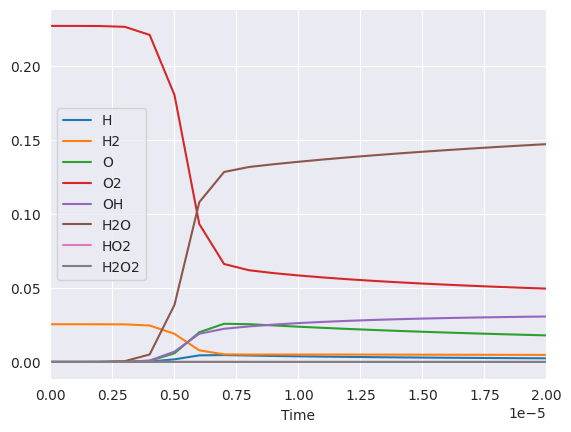

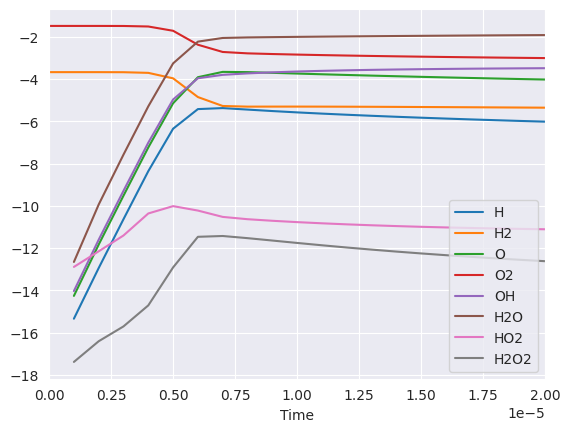

In [19]:
# Simulation number
i = 10

simu_i = dtb.data_simu[dtb.data_simu["Simulation number"]==i]

cols_species = simu_i.columns[2:-2]
cols_species = cols_species.drop("N2")
simu_i.set_index("Time")[cols_species].plot()
plt.xlim([0, 2e-5])
plt.savefig(folder + "/species_no_log.png", dpi=500)

simu_i_log = simu_i.copy()
simu_i_log[cols_species] = np.log(simu_i[cols_species])
simu_i_log.set_index("Time")[cols_species].plot()
plt.xlim([0, 2e-5])
plt.savefig(folder + "/species_log.png", dpi=500)

## Train/validation/test datasets 

Now that we have the simulations dataset, we need to split it into training/validation/test datasets to be able to carry on with ML training. A first option would be to take the *data_simu* array and select training/validation/test pointwise. In this specific 0D reactor case however, we prefer to split the dataset on a simulation basis. That is, we split the *n_samples* simulations into *n_training*, *n_validation* and *n_test* simulations for training, validation and test respectively.

We first set the ratios of simulations selected for validation and training:

In [ ]:
ratio_valid = 0.15
ratio_test = 0.15

The function *generate_train_valid_test*, part of the *Database_HomoReac* class, performs the following operations:

+ It splits the *n_samples* simulations into training, validation and test, as explained above.

+ It generates arrays of chemical states for training and validation: $(X_{train}, Y_{train})$ and $(X_{val}, Y_{val})$. The arrays for testing are not generated, we only save the initial conditions for the testing simulations and rerun them at testing time.

In the case of the *dt_cfd* solving, the ML time step corresponds to the time step in the *data_simu* array. Therefore, building the *Y* array can be done by simply shifting *Y* by one step. Conversely, for the *dt_cvode* sampling, the states corresponding to *t+dt* must be computed for each point, and the routine might take a bit longer.

In [ ]:
dtb.generate_train_valid_test(ratio_valid, ratio_test)

Selected simulations for train/validation/test can be accessed through *dtb.df_ODE_train*, *dtb.df_ODE_val*, *dtb.df_ODE_test*; and are also saved in csv files in the case folder. Test simulations conditions will in particular be reused later for testing the ML model.

The database are also stored in arrayx *dtb.X_train*, *dtb.Y_train*, *dtb.X_val* and *dtb.X_val*; and save in files for later use if necessary. We can have a look at *X_train* and *Y_train* for instance:

In [ ]:
dtb.X_train.head()

In [ ]:
dtb.Y_train.head()

Only the variables used as inputs/outputs are present in these dataframes. Unused variables, such as pressure, simulation time and number have been discarded. Note that the temperature is present as an input but not as an output. This is because here we will estimate the output temperature based on the conservation of enthalpy. It is a cheap and straightforward way to guarantee at least that energy is preserved and not let the ML algorithm choose for us.

## ML database preprocessing

By analyzing the profiles of $Y_k$ for 0D reactors we can spot at least two issues (see exercice 1 above):

1. The order of magnitude of species is very different: major species are of the order of $0.1$ while minor species can be $10^{-3}$-$10^{-2}$ and even much less for larger mechanisms. This will pose problems for learning, as the loss function will be dominated by major species.
2. The evolution of species mass fractions is very slow before ignition timing (sudden increase of species and temperature). Predicting such low reaction rate can also be an issue for ML algorithms.

To tackles these issues, two methods can be considered:

1. **Data scaling/normalization**: using knowledge of the data, we can normalize so that each species has an order of magnitude $\approx 1$. This will eliminate differences in order of magnitude.
2. **Data transformation**: as shown in exercice 1, applying a logarithm function ot the data leads to a linear evolution of $Y_k$'s in the first instants. This is more suitable for learning.

For the current database, we will first apply an (optional) logarithm transform and then a standard scaler.

We set a flag to decide if we apply the logarithm or not:

In [ ]:
log_transform = False

We devine new arrays which will contain the processed database:

In [ ]:
X_train_p = dtb.X_train.copy()
Y_train_p = dtb.Y_train.copy()
X_val_p = dtb.X_val.copy()
Y_val_p = dtb.Y_val.copy()

One issue with the logarithm is that we need to apply it to strictly positive data. We then need to clip the data to a certain threshold in order to guarantee that no NaN's will appear and corrupt the data. This threshold value is arbitrary and certainly has an impact on the learning. 

*Exercice 2:* Set the threshold on the trainign and validation databases and apply the logarithm. For $X$, the logarithm should be applied on species mass fractions only, not on temperature.

In [ ]:
threshold = 1.0e-10
if log_transform:
    X_train_p[X_train_p < threshold] = threshold
    X_val_p[X_val_p < threshold] = threshold
    #
    Y_train_p[Y_train_p < threshold] = threshold
    Y_val_p[Y_val_p < threshold] = threshold

    # Apply log
    X_train_p.iloc[:, 1:] = np.log(X_train_p.iloc[:, 1:])
    X_val_p.iloc[:, 1:] = np.log(X_val_p.iloc[:, 1:])
    #
    Y_train_p = np.log(Y_train_p)
    Y_val_p = np.log(Y_val_p)

In the present work, we select the standard scaler. For a given variable $\psi$, the normalization is:

$$
\psi^n = \frac{\psi - \mu}{\sigma}
$$

where $\mu$ is the mean of $\psi$ and $\sigma$ its standard deviation. The inverse transform reads:

$$
\psi = \sigma \psi^n + \mu
$$

A function *StandardScaler* is given in the *utils.py* script. It features three functions:

+ *fit*: compute mean and standard deviation.
+ *transform*: performs the transform.
+ *inverse_transform*: performes the inverse transform.

*Exercice 3*: Perform the scaling of the data, by using training data to set the parameters and applying it on both train and validation. 

In [ ]:
Xscaler = StandardScaler()
Xscaler.fit(X_train_p)
X_train_p = Xscaler.transform(X_train_p)
X_val_p = Xscaler.transform(X_val_p)

Yscaler = StandardScaler()
Yscaler.fit(Y_train_p)
Y_train_p = Yscaler.transform(Y_train_p)
Y_val_p = Yscaler.transform(Y_val_p)

We can have a look at the training database:

In [ ]:
X_train_p.head()

In [ ]:
Y_train_p.head()

We save the scalers for later use in training routine:

In [ ]:
folder_p = os.path.join(folder,"processed_database")
if not os.path.isdir(folder_p):
    os.mkdir(folder_p)

joblib.dump(Xscaler, os.path.join(folder_p,'Xscaler.pkl'))
joblib.dump(Yscaler, os.path.join(folder_p,'Yscaler.pkl'))

We save the processed training and validation databases:

In [ ]:
X_train_p.to_csv(os.path.join(folder_p,"X_train.csv"), index=False)
Y_train_p.to_csv(os.path.join(folder_p,"Y_train.csv"), index=False)
X_val_p.to_csv(os.path.join(folder_p,"X_val.csv"), index=False)
Y_val_p.to_csv(os.path.join(folder_p,"Y_val.csv"), index=False)

We save some parameters in a json file for later use in the ML learning notebook:

In [ ]:
params = {
        "fuel": fuel,
        "mech_file": mech_file,
        "log_transform": log_transform,
        "threshold": threshold,
        "p": p,
        "dt": dt,
        }

# Save to file
with open(os.path.join(folder, "dtb_params.json"), "w") as file:
    json.dump(params, file)